In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import csv

In [8]:
# pd.set_option('display.max_rows', 100)
# pd.set_option('max_colwidth', 500)
# pd.set_option('display.max_columns', 500)

reviews = pd.read_csv('reviews.csv')
# reviews.head()
df_host = pd.read_csv('listings_cleaned.csv')
# df_host.head(10)

In [9]:
#removing unnecessary columns
#can do this much more efficiently later
host_filtered = df_host.drop(df_host.iloc[:, 11:59], axis = 1)
host_filtered.head()
# reviews.head()

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,...,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,n_bathrooms,shared_private
0,177,https://www.airbnb.com/rooms/177,20210722142814,2021-07-23,Tiny Home in the Heart of the City- ECO FRIENDLY,"160 sq ft + 80 sq ft loft for sleeping, Sleeps...","Quiet neighborhood next to park, creeks and bi...",https://a0.muscache.com/pictures/a1745ab2-b3a0...,615,https://www.airbnb.com/users/show/615,...,4.76,2016-BFN-0004968,f,2,2,0,0,1.49,1.0,private
1,360,https://www.airbnb.com/rooms/360,20210722142814,2021-07-23,Sit in the Peaceful Garden of the Chickadee Co...,Enjoy the famous Colorado weather and unplug i...,The cottage is located in the center of Lower ...,https://a0.muscache.com/pictures/monet/Select-...,666,https://www.airbnb.com/users/show/666,...,4.91,2017-BFN-0002177,f,2,2,0,0,8.98,1.0,private
2,364,https://www.airbnb.com/rooms/364,20210722142814,2021-07-23,Lodo / RiNo LOFT via airport train,"Modern 1,000 square foot loft in the heart of ...","Ten brewpubs within walking distance, two grea...",https://a0.muscache.com/pictures/11766413/a2c5...,783,https://www.airbnb.com/users/show/783,...,4.71,NaN,f,1,1,0,0,0.70,1.5,private
3,590,https://www.airbnb.com/rooms/590,20210722142814,2021-07-23,Comfortable - and a great value!,"Large guest room in my home, where I also live...",I love the diversity of my neighborhood and it...,https://a0.muscache.com/pictures/110931/30991c...,933,https://www.airbnb.com/users/show/933,...,4.84,2021-BFN-0000578,f,2,0,2,0,7.26,1.0,shared
4,592,https://www.airbnb.com/rooms/592,20210722142814,2021-07-23,private,This room is in the basement. It does not hav...,NaN,https://a0.muscache.com/pictures/miso/Hosting-...,933,https://www.airbnb.com/users/show/933,...,4.85,2021-BFN-0000578,f,2,0,2,0,1.14,1.0,shared


In [10]:
host_filtered.drop(['scrape_id', 'last_scraped', 'name', 'description', 'neighborhood_overview', 'picture_url', 'host_id', 'host_url', 'last_review'], axis = 1, inplace = True)

In [11]:
host_filtered.drop(host_filtered.iloc[:, 10:], axis = 1, inplace = True)
host_filtered.head()

,id,listing_url,host_name,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value
0,177,https://www.airbnb.com/rooms/177,Joe,4.80,4.96,4.86,4.96,4.93,4.83,4.76
1,360,https://www.airbnb.com/rooms/360,Jennifer & Giovanni,4.99,4.99,4.96,5.00,5.00,5.00,4.91
2,364,https://www.airbnb.com/rooms/364,Jason,4.85,4.78,4.81,4.95,4.96,4.65,4.71
3,590,https://www.airbnb.com/rooms/590,Jill,4.84,4.76,4.56,4.92,4.95,4.74,4.84
4,592,https://www.airbnb.com/rooms/592,Jill,4.85,4.75,4.55,4.94,4.94,4.80,4.85


In [12]:
#renaming columns for merge on ID/listng ID
reviews.drop(['reviewer_id', 'id'], axis = 1, inplace = True)
reviews.rename(columns = {'listing_id': 'id'}, inplace = True)
reviews.head()

,id,date,reviewer_name,comments
0,177,2016-09-04,Brenna,"Great place to stay! Definitely a tiny home, b..."
1,177,2016-09-13,Rachael,Joe was very friendly and gave us all the info...
2,177,2016-09-14,Haley,Amazing property and Joe was a great host! Eve...
3,177,2016-09-19,Mike,"Joe was a great host, the description of this ..."
4,177,2016-09-22,Carol,He welcomes us when we first arrived and gave ...


In [13]:
df_stars = host_filtered.drop(df_host.iloc[:, 1:2], axis = 1)
df_stars.head(10)

,id,host_name,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value
0,177,Joe,4.80,4.96,4.86,4.96,4.93,4.83,4.76
1,360,Jennifer & Giovanni,4.99,4.99,4.96,5.00,5.00,5.00,4.91
2,364,Jason,4.85,4.78,4.81,4.95,4.96,4.65,4.71
3,590,Jill,4.84,4.76,4.56,4.92,4.95,4.74,4.84
4,592,Jill,4.85,4.75,4.55,4.94,4.94,4.80,4.85
5,686,Alexandra,4.77,4.77,4.81,4.86,4.92,4.87,4.83
6,1940,Joanne,4.93,4.93,4.93,5.00,4.97,4.92,4.88
7,31503,Rick,4.89,4.89,5.00,4.93,4.99,4.86,4.89
8,39405,Jennifer & Giovanni,4.91,4.88,4.93,4.98,4.97,4.84,4.85
9,74125,Joe,4.73,4.80,4.30,4.91,4.97,4.86,4.71


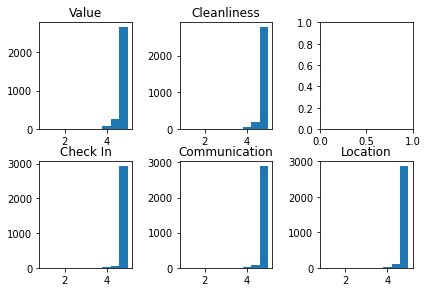

In [14]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 3)
fig.tight_layout()

ax[0, 0].hist(df_stars["review_scores_value"]) #row=0, col=0
ax[0, 0].set_title('Value')
ax[1, 0].hist(df_stars["review_scores_checkin"]) #row=1, col=0
ax[1, 0].set_title('Check In')
ax[0, 1].hist(df_stars["review_scores_cleanliness"]) #row=0, col=1
ax[0, 1].set_title('Cleanliness')
ax[1, 1].hist(df_stars["review_scores_communication"]) #row=1, col=1
ax[1, 1].set_title('Communication')
ax[1, 2].hist(df_stars["review_scores_location"]) #row=1, col=2
ax[1 ,2].set_title('Location')
plt.show()

In [15]:
#plot score rating by loc
#if host has multiple listings, take average

#appending price col to host_filtered
price = df_host['price']

host_filtered = host_filtered.join(price)
host_filtered.head()


,id,listing_url,host_name,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,price
0,177,https://www.airbnb.com/rooms/177,Joe,4.80,4.96,4.86,4.96,4.93,4.83,4.76,99.0
1,360,https://www.airbnb.com/rooms/360,Jennifer & Giovanni,4.99,4.99,4.96,5.00,5.00,5.00,4.91,135.0
2,364,https://www.airbnb.com/rooms/364,Jason,4.85,4.78,4.81,4.95,4.96,4.65,4.71,179.0
3,590,https://www.airbnb.com/rooms/590,Jill,4.84,4.76,4.56,4.92,4.95,4.74,4.84,55.0
4,592,https://www.airbnb.com/rooms/592,Jill,4.85,4.75,4.55,4.94,4.94,4.80,4.85,52.0


In [16]:
df_merged = pd.merge(reviews, host_filtered, on = 'id')
#Removing review scores for this df
df_merged.drop(df_merged.iloc[:, 7:12], axis = 1, inplace = True)
df_merged.head()

,id,date,reviewer_name,comments,listing_url,host_name,review_scores_rating,review_scores_value,price
0,177,2016-09-04,Brenna,"Great place to stay! Definitely a tiny home, b...",https://www.airbnb.com/rooms/177,Joe,4.8,4.76,99.0
1,177,2016-09-13,Rachael,Joe was very friendly and gave us all the info...,https://www.airbnb.com/rooms/177,Joe,4.8,4.76,99.0
2,177,2016-09-14,Haley,Amazing property and Joe was a great host! Eve...,https://www.airbnb.com/rooms/177,Joe,4.8,4.76,99.0
3,177,2016-09-19,Mike,"Joe was a great host, the description of this ...",https://www.airbnb.com/rooms/177,Joe,4.8,4.76,99.0
4,177,2016-09-22,Carol,He welcomes us when we first arrived and gave ...,https://www.airbnb.com/rooms/177,Joe,4.8,4.76,99.0


In [17]:
#Check missing values
df_merged.drop(['review_scores_value'], axis = 1, inplace = True)
df_merged['comments'].isna().sum()

134

In [18]:
import itertools
import collections

#convert text to lowercase
def convert(lst): 
    return ([i for item in lst for i in item.lower().split()]) 

filtered_comments = convert(df_merged['comments'].fillna("")) #Fill in missing reviews with blank


In [19]:
count_word = collections.Counter(filtered_comments) #Count word frequency

clean_word_count = pd.DataFrame(count_word.most_common(5),
                             columns=['words', 'count'])

clean_word_count.head()


,words,count
0,and,427974
1,the,368712
2,to,267911
3,a,256889
4,was,231467


In [20]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /Users/yobae/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [21]:
stop_words = set(stopwords.words(['english']))
#View sample set of stopwords
list(stop_words)[0:10]

['him', "aren't", 'o', 'yours', 'both', 'few', "isn't", 'hasn', 'who', 'other']

In [22]:
words_review_cleaned = [word for word in filtered_comments if word not in stop_words]
words_review_count = collections.Counter(words_review_cleaned)

word_review_count_df = pd.DataFrame(words_review_count.most_common(15),
                             columns=['words', 'count'])

In [23]:
import matplotlib.pyplot as plt

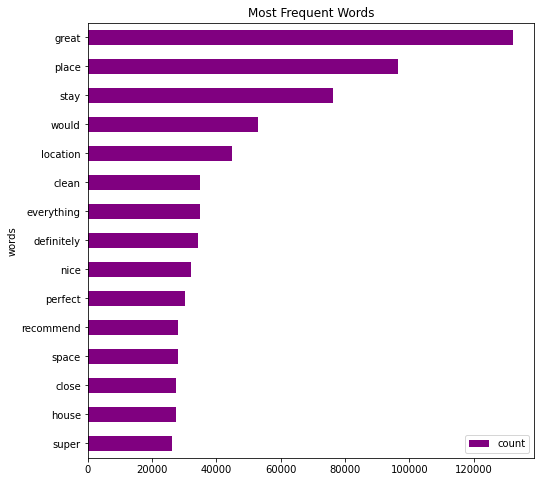

In [24]:
fig, ax = plt.subplots(figsize=(8, 8))

# Plot horizontal bar graph
word_review_count_df.sort_values(by='count').plot.barh(x='words',
                      y='count',
                      ax=ax,
                      color="purple")

ax.set_title("Most Frequent Words")

plt.show()

In [25]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 215316 entries, 0 to 215315
Data columns (total 8 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    215316 non-null  int64  
 1   date                  215316 non-null  object 
 2   reviewer_name         215316 non-null  object 
 3   comments              215182 non-null  object 
 4   listing_url           215316 non-null  object 
 5   host_name             215316 non-null  object 
 6   review_scores_rating  214443 non-null  float64
 7   price                 215316 non-null  float64
dtypes: float64(2), int64(1), object(5)
memory usage: 14.8+ MB


In [26]:
df_merged.shape
# df_sample_set = df_merged.iloc[0:100000, :]
# df_sample_set.head()

(215316, 8)

In [27]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/yobae/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [28]:
#Identifying PScores with builtin Vader SIA
SIA = SentimentIntensityAnalyzer()

positive sentiment: score >= 0.05
neutral sentiment: score > -0.05 and score < 0.05
negative sentiment: score <= -0.05

In [22]:
df_sample_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    100000 non-null  int64  
 1   date                  100000 non-null  object 
 2   reviewer_name         100000 non-null  object 
 3   comments              99954 non-null   object 
 4   listing_url           100000 non-null  object 
 5   host_name             100000 non-null  object 
 6   review_scores_rating  99996 non-null   float64
 7   price                 100000 non-null  float64
dtypes: float64(2), int64(1), object(5)
memory usage: 6.9+ MB


In [29]:
# df_sample_set.drop(['listing_url', 'host_name', 'price'], axis = 1, inplace = True)
df_merged.drop(['listing_url', 'host_name'], axis = 1, inplace = True)

In [30]:
df_merged['comments'] = df_merged["comments"].apply(str)

In [31]:
# df_sample_set.fillna(0, inplace = True)
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 215316 entries, 0 to 215315
Data columns (total 6 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    215316 non-null  int64  
 1   date                  215316 non-null  object 
 2   reviewer_name         215316 non-null  object 
 3   comments              215316 non-null  object 
 4   review_scores_rating  214443 non-null  float64
 5   price                 215316 non-null  float64
dtypes: float64(2), int64(1), object(3)
memory usage: 11.5+ MB


In [32]:
from nltk.stem import PorterStemmer, WordNetLemmatizer

More data clenaing
Extracting root words and removing punctuation etc.

In [33]:
#Grabbing root words
p_stemmer = PorterStemmer()
def stem(sentence):
    tokens = sentence.split()
    stemmed_tokens = [p_stemmer.stem(token) for token in tokens]
    return ' '.join(stemmed_tokens)

# df_sample_set = df_sample_set[df_sample_set['comments'].notnull()]
df_merged = df_merged[df_merged['comments'].notnull()]
df_merged['comments'] = df_merged['comments'].apply(stem)

In [34]:
pd.options.mode.chained_assignment = None
stopwords_list = set(stopwords.words("english"))
#List of punctuation to remove
#Handle html tags?
punctuations = """!()-![]{};:,+'"\,<>./?@#$%^&*_~Â""" 

def reviewParse(comments):
    #Split the review into words
    splitReview = comments.split()
    #Takes punctuation out
    parsedReview = " ".join([word.translate(str.maketrans('', '', punctuations)) + " " for word in splitReview])
    return parsedReview
  
def clean_review(comments):
    #Makes all words lowercase
    clean_words = []
    splitReview = comments.split()
    for w in splitReview:
        if w.isalpha() and w not in stopwords_list:
            clean_words.append(w.lower())
    #Joins split words back into sentence
    clean_review = " ".join(clean_words)
    return clean_review

df_merged = df_merged[df_merged['comments'].notnull()]
df_merged['comments'] = df_merged['comments'].apply(reviewParse).apply(clean_review)

In [35]:
#This does not properly rounds all values, no 1 or 2 ratings
#Need to find way to properly round values down beforehand
# df_sample_set['review_scores_rating'] = df_sample_set['review_scores_rating'].astype(np.int64)
# df_sample_set.info()
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 215316 entries, 0 to 215315
Data columns (total 6 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    215316 non-null  int64  
 1   date                  215316 non-null  object 
 2   reviewer_name         215316 non-null  object 
 3   comments              215316 non-null  object 
 4   review_scores_rating  214443 non-null  float64
 5   price                 215316 non-null  float64
dtypes: float64(2), int64(1), object(3)
memory usage: 11.5+ MB


In [35]:
# # df_sample_set['Sentiment'] = df_sample_set['review_scores_rating'].round(decimals = 2).apply(sentiment)
# # df_sample_set.loc('comments')
# df_test = pd.DataFrame()
# # df_test['sentiment'] = df_test['round_review'].apply(sentiment)
# # print(type(df_clean['review_scores_rating']))
# df_test.info()
# # df_test.head()

In [36]:
docs = list(df_merged['comments'])[:200000]

- tfidf(t, d, D) = tf(t, d) * idf(t, D)
- t = term
- d = document
- D = set of documents
- TF-IDF provides a weight
- This weight is a statistical measure used to evaluate how important 
a word is to a document in a collection or corpus. 
- The importance increases proportionally to the number of times a 
word appears in the document but is offset by the frequency of 
the word in the corpus (data-set).

In [37]:
#Running SIA on cleaned dataset
SIA = SentimentIntensityAnalyzer()
for sentence in df_merged['comments'].values[:5]:
    print(sentence)
    ss = SIA.polarity_scores(sentence)
    for k in sorted(ss):
        print('{0}: {1}, '.format(k, ss[k]), end='')
    print()

great place stay definit tini home still cozi comfortable pretti fun tri coupl night two us joe wa help friendly destin alway less drive lot park nearby super fun stay
compound: 0.9744, neg: 0.0, neu: 0.491, pos: 0.509, 
joe wa veri friendli gave us inform needed hous wa exactli describ site wa fun thought provok experienc ecofriendli space plan stay next time wer denver
compound: 0.5106, neg: 0.0, neu: 0.883, pos: 0.117, 
amaz properti joe wa great host even offer walk dog definit back
compound: 0.6249, neg: 0.0, neu: 0.728, pos: 0.272, 
joe wa great host descript thi tini hous wa spot wa definit small space well laid veri convenient would recommend stay
compound: 0.8271, neg: 0.0, neu: 0.674, pos: 0.326, 
welcom us first arriv gave great recommend dinnerbreakfast
compound: 0.765, neg: 0.0, neu: 0.476, pos: 0.524, 


In [38]:
#Correlation between original stars rating and price is low
corr_1 = df_host["review_scores_rating"]
corr_2 = df_host["price"]
correlation = corr_2.corr(corr_1)
print(correlation)

0.03934857745018719


In [39]:
from sklearn.feature_extraction.text import TfidfVectorizer 
 
#Settings for count vectorizer
tfidf_vectorizer = TfidfVectorizer(use_idf=True, max_features = 100000) 
 
#Send all docs here 
tfidf_vectorizer_vectors = tfidf_vectorizer.fit_transform(docs)

In [40]:
import plotly.graph_objs as go

In [41]:
fig = go.Figure([go.Bar(x = df_merged.review_scores_rating.value_counts().index, y = df_merged.review_scores_rating.value_counts().tolist())])
fig.update_layout(
    title="Values in each Sentiment",
    xaxis_title = "Sentiment",
    yaxis_title = "Values")
fig.show()

In [4]:
df_train_set = df_merged.dropna()
df_train_set.head(10)
# df_train_set.to_csv("airbnb-train-set.csv",index=False)

NameError: name 'df_merged' is not defined

In [43]:
# tfidf_vectorizer.get_feature_names()
df_train_set.drop_duplicates(inplace=True)
X = tfidf_vectorizer_vectors.toarray()
Y = df_train_set['review_scores_rating'].astype(int)[:200000]

In [44]:
len(X[0])

53645

In [3]:
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV 
from sklearn.metrics import mean_absolute_error, accuracy_score, confusion_matrix, classification_report, roc_auc_score,roc_curve,auc
from sklearn.tree import DecisionTreeClassifier

#Dividing into train and validation sets

SEED = 123

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = SEED, stratify = Y)

NameError: name 'X' is not defined

In [2]:
dt = DecisionTreeClassifier(random_state=SEED)
dt.fit(X_train,y_train)
y_pred_test = dt.predict(X_test)
print("Training Accuracy score: "+str(round(accuracy_score(y_train,dt.predict(X_train)),4)))
print("Testing Accuracy score: "+str(round(accuracy_score(y_test,dt.predict(X_test)),4)))

NameError: name 'SEED' is not defined

In [167]:
#Must assign neutral values to positive
#Neutral scores tend to have positive sentiment utilizing neutral words
print(classification_report(y_test, y_pred_test, target_names = ['positive', 'negative']))

              precision    recall  f1-score   support

    positive       0.99      1.00      0.99      1979
    negative       0.50      0.43      0.46        21

    accuracy                           0.99      2000
   macro avg       0.75      0.71      0.73      2000
weighted avg       0.99      0.99      0.99      2000



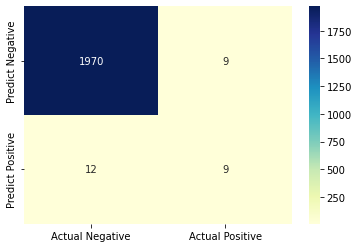

In [172]:
cm = confusion_matrix(y_test, y_pred_test)
#print('Confusion matrix\n', cm)
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Negative', 'Actual Positive'], 
                        index=['Predict Negative', 'Predict Positive'])
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.show()

In [173]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred_train = gnb.predict(X_train)
y_pred_test = gnb.predict(X_test)
print("Training Accuracy score: " + str(round(accuracy_score(y_train, gnb.predict(X_train)), 4)))
print("Testing Accuracy score: " + str(round(accuracy_score(y_test, gnb.predict(X_test)), 4)))

Training Accuracy score: 0.9132
Testing Accuracy score: 0.9025


In [175]:
print(classification_report(y_test, y_pred_test, target_names=['positive', 'negative']))

              precision    recall  f1-score   support

    positive       0.99      0.91      0.95      1979
    negative       0.02      0.14      0.03        21

    accuracy                           0.90      2000
   macro avg       0.50      0.53      0.49      2000
weighted avg       0.98      0.90      0.94      2000



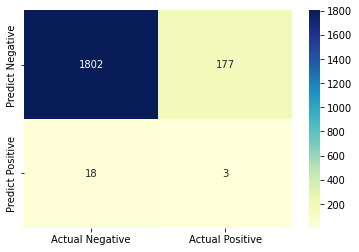

In [176]:
cm = confusion_matrix(y_test, y_pred_test)
#print('Confusion matrix\n', cm)
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Negative', 'Actual Positive'], 
                        index=['Predict Negative', 'Predict Positive'])
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.show()

In [177]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state=SEED).fit(X_train, y_train)
y_pred_train = lr.predict(X_train)
y_pred_test = lr.predict(X_test)
print("Training Accuracy score: "+str(round(accuracy_score(y_train,lr.predict(X_train)),4)))
print("Testing Accuracy score: "+str(round(accuracy_score(y_test,lr.predict(X_test)),4)))

Training Accuracy score: 0.9895
Testing Accuracy score: 0.9895


In [180]:
print(classification_report(y_test, y_pred_test, target_names=['positive', 'negative']))

              precision    recall  f1-score   support

    positive       0.99      1.00      0.99      1979
    negative       0.00      0.00      0.00        21

    accuracy                           0.99      2000
   macro avg       0.49      0.50      0.50      2000
weighted avg       0.98      0.99      0.98      2000



/opt/homebrew/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/homebrew/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/homebrew/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



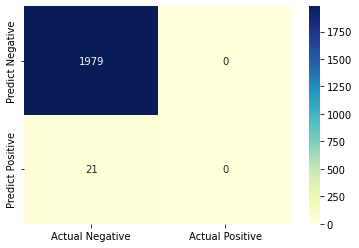

In [181]:
cm = confusion_matrix(y_test, y_pred_test)
#print('Confusion matrix\n', cm)
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Negative', 'Actual Positive'], 
                        index=['Predict Negative', 'Predict Positive'])
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.show()

In [182]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
print("Training Accuracy score: "+str(round(accuracy_score(y_train,clf.predict(X_train)), 4)))
print("Testing Accuracy score: "+str(round(accuracy_score(y_test,clf.predict(X_test)), 4)))

Training Accuracy score: 1.0
Testing Accuracy score: 0.9895


In [183]:
print(classification_report(y_test, y_pred_test, target_names=['positive', 'negative']))

              precision    recall  f1-score   support

    positive       0.99      1.00      0.99      1979
    negative       0.00      0.00      0.00        21

    accuracy                           0.99      2000
   macro avg       0.49      0.50      0.50      2000
weighted avg       0.98      0.99      0.98      2000



/opt/homebrew/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/homebrew/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/homebrew/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



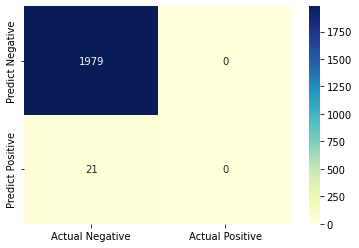

In [184]:
cm = confusion_matrix(y_test, y_pred_test)
#print('Confusion matrix\n', cm)
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Negative', 'Actual Positive'], 
                        index=['Predict Negative', 'Predict Positive'])
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.show()

In [185]:
from sklearn.ensemble import VotingClassifier

classifiers = [('Decision Tree', dt),
               ('Logistic Regression', lr),
                ('Naive Bayes', gnb)
              ]
vc = VotingClassifier(estimators=classifiers)
# Fit 'vc' to the traing set and predict test set labels
vc.fit(X_train, y_train)

print("Training Accuracy score: " + str(round(accuracy_score(y_train,vc.predict(X_train)), 4)))
print("Testing Accuracy score: " + str(round(accuracy_score(y_test,vc.predict(X_test)), 4)))

Training Accuracy score: 1.0
Testing Accuracy score: 0.9885


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, mean_absolute_error

In [186]:
predictions = pd.Series(lr.predict(X), name="sentiment")
results = pd.concat([predictions],axis=1)
results.to_csv("airbnb-review-sentiment.csv",index=False)

Hence we successfully studied various models like Decision Tree, SVM, Naive Bayes and Logistic Regression and implemented them for the given dataset as part of the experiment along with a comparative analysis of various metrics and made the following observations.

Naïve Bayes and Decision Tree are susceptible to noise if present in the dataset because when we reduced the number of features by considering only the most frequent words the accuracy and AUC score increased significantly.
Logistic Regression and SVM performed almost same for the given dataset even with the initial number of features.
We can increase Accuracy marginally by removing Named Entities using spacy and performing Lemmatization on top of that on all the models mentioned above.

In [187]:
# add sentiment anaylsis columns
# df_sample_set["sentiment_scores"] = df_sample_set["comments"].apply(lambda x: SIA.polarity_scores(x))
# df_sample_set = pd.concat([df_sample_set.drop(['sentiment_scores'], axis = 1), df_sample_set['sentiment_scores'].apply(pd.Series)], axis = 1)
# df_sample_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    100000 non-null  int64  
 1   date                  100000 non-null  object 
 2   reviewer_name         100000 non-null  object 
 3   comments              100000 non-null  object 
 4   listing_url           100000 non-null  object 
 5   host_name             100000 non-null  object 
 6   review_scores_rating  99996 non-null   float64
 7   price                 100000 non-null  float64
 8   neg                   100000 non-null  float64
 9   neu                   100000 non-null  float64
 10  pos                   100000 non-null  float64
 11  compound              100000 non-null  float64
dtypes: float64(6), int64(1), object(5)
memory usage: 9.9+ MB


In [ ]:
#Calculates pscores (builtin nltk sentiment analysis)
pscores = [SIA.polarity_scores(comments) for comments in df_merged['comments']]

Text(0, 0.5, 'frequency')

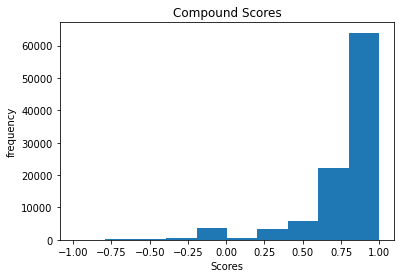

In [65]:
pd.Series([score['compound'] for score in pscores]).plot(kind = 'hist')
plt.title('Compound Scores')
plt.xlabel('Scores')
plt.ylabel('frequency')

Text(0, 0.5, 'Frequency')

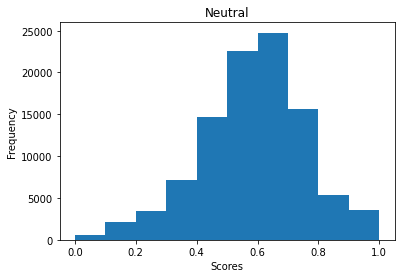

In [66]:
pd.Series([score['neu'] for score in pscores]).plot(kind='hist')
plt.title('Neutral')
plt.xlabel('Scores')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

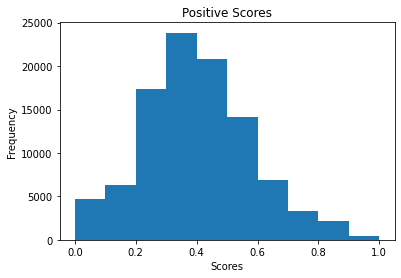

In [67]:
pd.Series([score['pos'] for score in pscores]).plot(kind='hist')
plt.title('Positive Scores')
plt.xlabel('Scores')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

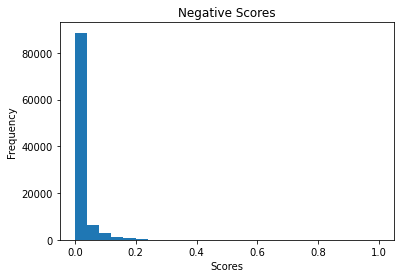

In [70]:
pd.Series([score['neg'] for score in pscores]).plot(kind='hist', bins=25)
plt.title('Negative Scores')
plt.xlabel('Scores')
plt.ylabel('Frequency')

In [71]:
scored_reviews = pd.DataFrame()
scored_reviews['review'] = [r for r in df_sample_set['comments']]
scored_reviews['compound'] = [score['compound'] for score in pscores]
scored_reviews['negativity'] = [score['neg'] for score in pscores]
scored_reviews['neutrality'] = [score['neu'] for score in pscores]
scored_reviews['positivity'] = [score['pos'] for score in pscores]

In [72]:
scored_reviews.query('negativity > 0')

,review,compound,negativity,neutrality,positivity
10,enjoy privaci hospit dure stay joe wa veri und...,0.5267,0.070,0.758,0.173
15,thi tini hous wa wonderful joe wa excel explai...,0.9887,0.039,0.684,0.277
16,great experi anyon consid go tiny love cozi li...,0.8176,0.044,0.754,0.202
20,thi wa experi would keep everyth book checkout...,0.9592,0.029,0.721,0.250
21,quaint cozi setting compost toilet amazing mes...,0.3182,0.153,0.613,0.233
...,...,...,...,...,...
99972,cute cozy privat bedroom basement apartment fu...,0.4215,0.047,0.857,0.096
99973,ask wa possibl check earli host work hard acco...,0.6486,0.047,0.764,0.189
99979,space wa veri clean nice famili wonder hospita...,0.7790,0.028,0.814,0.158
99990,thi two bedroom two bath contemporari loft bea...,0.9698,0.031,0.711,0.258


Not many negative reviews

In [74]:
scored_reviews.query('negativity > positivity').query('negativity > 0.1')

,review,compound,negativity,neutrality,positivity
30,joe host made us veri uncomfortable left town ...,-0.7466,0.251,0.677,0.072
35,host cancel thi reserv day befor arrival thi a...,-0.2500,0.182,0.818,0.000
623,jill place wa great valu indeed bu stop close ...,0.2910,0.111,0.791,0.098
723,start trip us jill veri short notice couldnt f...,-0.2537,0.188,0.708,0.104
762,host wa extrem commun thi lower stress level b...,-0.2023,0.113,0.814,0.072
...,...,...,...,...,...
99136,host cancel thi reserv day befor arrival thi a...,-0.2500,0.182,0.818,0.000
99180,get pay,-0.1027,0.583,0.417,0.000
99215,host cancel thi reserv day befor arrival thi a...,-0.2500,0.182,0.818,0.000
99242,setup stay amin place dure major renov build w...,-0.5600,0.144,0.741,0.115


In [65]:
#TODO: nltk built in sentiment analysis seems to be not as accurate as I'd like
# marking comments negative even though overall sentiment is positive

In [128]:
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from nltk.stem import WordNetLemmatizer
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.pipeline import Pipeline
nltk.download(['punkt', 'wordnet', 'stopwords'])
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords

[nltk_data] Downloading package punkt to /Users/yobae/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /Users/yobae/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /Users/yobae/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [129]:
def tokenize(text):
    '''
    Input: Text String (str)
    
    Process: 
    1. Tokenize text into tokens
    2. Remove stop words
    3. Lemmatize
    
    Output: List of text tokens for string
    '''
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english')) 
    lemmatizer = WordNetLemmatizer()
    tokens = [w for w in tokens if not w in stop_words]
    tokens = [lemmatizer.lemmatize(w.lower().strip()) for w in tokens]
    return tokens

In [130]:
# Initialize ML pipeline
pipeline = Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize)),
    ('tfidf', TfidfTransformer()),
    ('clf', RandomForestRegressor())
])

In [131]:
df_test = df_sample_set.dropna()
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99996 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    99996 non-null  int64  
 1   date                  99996 non-null  object 
 2   reviewer_name         99996 non-null  object 
 3   comments              99996 non-null  object 
 4   listing_url           99996 non-null  object 
 5   host_name             99996 non-null  object 
 6   review_scores_rating  99996 non-null  float64
 7   price                 99996 non-null  float64
dtypes: float64(2), int64(1), object(5)
memory usage: 6.9+ MB


In [134]:
# Import train_test_split, Split data
from sklearn.model_selection import train_test_split
X = df_test['comments']
Y = df_test['price']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2)

In [ ]:
# Fit pipeline
# Takes too long to run
pipeline.fit(X_train, y_train)

In [ ]:
y_preds = pipeline.predict(X_test)

In [ ]:
mean_squared_error(y_test, y_preds)

In [ ]:
from math import sqrt
rmse = sqrt(mean_squared_error(y_test, y_preds))
rmse

In [ ]:
y_preds[:10]

In [ ]:
# # Re-format the comments for each listing_id to a list instead of series
# from langdetect import detect
# base_dict = dict(tuple(df_sample_set.groupby("id")))
# sentiment_dict = {}
# listing_ids = []

# for listing_id in base_dict:
#     base_dict[listing_id] = base_dict[listing_id]["comments"].values.tolist()
#     # These four variables will hold the comments/features classified as positive/negative based on polarity
#     negative_comments_list = []
#     positive_comments_list = []
#     negative_features_list = {}
#     positive_features_list = {}
#     sentiment_score = 0  # The overall sentiment polarity of the listing

#     # For every review in each listing_id
#     for comment in base_dict[listing_id]:

#         # Use a try/catch block to catch errors where langdetect cannot identify the language of the comment
#         try:

#             # Only proceed if the comment is in English
#             if detect(comment) == "en":

#                 # Maintain a list of listing_ids with valid English reviews
#                 if listing_id not in listing_ids:
#                     listing_ids.append(listing_id)

#                 # Generate a sentiment score (with polarity) for the given review
#                 ss = SIA.polarity_scores(comment)

#                 """ 
#                 We classify neutral (0) reviews as positive since manual analysis of tweets indicate that neutrally classified comments 
#                 simply used 'neutral language' to praise a listing as opposed to the sentiments actually being neutral
#                 """
#                 # If the comment is negative, place it in the negative comments list and update the sentiment score of the overall listing
#                 if ss["compound"] < 0:
#                     negative_comments_list.append(comment.strip())
#                     sentiment_score += ss["compound"]

#                 # If the comment is positive, place it in the positive comments list and update the sentiment score of the overall listing
#                 if ss["compound"] >= 0:
#                     positive_comments_list.append(comment.strip())
#                     sentiment_score += ss["compound"]
#         except Exception as identifier:
#                 pass

# # Populate the listing_id key with the accumulated results of the sentiment analysis over all comments for a given listing
#     if len(positive_comments_list) + len(negative_comments_list) == 0:
#         sentiment_score = 0
#     else:
#         sentiment_score = sentiment_score / (
#             len(positive_comments_list) + len(negative_comments_list)
#         )

#     sentiment_dict[listing_id] = {
#         "positive_comments": positive_comments_list,
#         "negative_comments": negative_comments_list,
#         "positive_features": positive_features_list,
#         "negative_features": negative_features_list,
#         "sentiment_score": (
#             sentiment_score  # This score is an average score over all listing reviews
#         ),
#     }

#     # Now that population of each comment and feature is complete, we can generate data for this listing
#     for sentiment in ["positive_features", "negative_features"]:

#         # Initialize a dataframe from the sentiment dictionary and sort by # of times feature was mentioned
#         sent_df = pd.DataFrame.from_dict(
#             sentiment_dict[listing_id][sentiment],
#             orient="index",
#             columns=["count", "adjectives"],
#         ).sort_values(by="count", ascending=False)
